In [4]:
%matplotlib inline

!pip install scikit-plot

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from scikitplot.metrics import plot_roc
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

df_train=pd.read_csv("ravdess_features_train.csv")
df_test=pd.read_csv("ravdess_features_test.csv")

df_train["emotion"]=df_train["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_train["emotional_intensity"]=df_train["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_train["sex"]=df_train["sex"].replace(["M", "F"],[0,1])
df_train["statement"]=df_train["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_train["vocal_channel"]=df_train["vocal_channel"].replace(["speech", "song"],[0,1])
y_train=df_train.emotion.values
X_train=df_train.drop(columns=["emotion"]).values

df_test["emotion"]=df_test["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_test["emotional_intensity"]=df_test["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_test["sex"]=df_test["sex"].replace(["M", "F"],[0,1])
df_test["statement"]=df_test["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_test["vocal_channel"]=df_test["vocal_channel"].replace(["speech", "song"],[0,1])
y_test=df_test.emotion.values
X_test=df_test.drop(columns=["emotion"]).values

frames = [df_train, df_test]
df = pd.concat(frames)
X = df.drop(columns=["emotion"]).values
X_unscaled = df.drop(columns=["emotion"]).values
y=df.emotion.values

Defaulting to user installation because normal site-packages is not writeable


## Box plots

In [5]:
def is_outlier(x, k=1.5):
    q1 = np.quantile(x, 0.25)
    q3 = np.quantile(x, 0.75)
    iqr = q3 - q1
    outliers = list()
    for v in x:
        if v < q1 - k * iqr or v > q3 + k * iqr:
            outliers.append(True)
        else:
            outliers.append(False)
    return np.array(outliers)

In [6]:
outliers = []
for i in range(X.shape[1]):
    outliers.append(np.unique(is_outlier(X[:,i], k=1.5), return_counts=True))

In [7]:
n_outliers = []
for i in range(X.shape[1]):
    if len(outliers[i][1]) == 2:
        n_outliers.append(outliers[i][1][1])
    else:
        n_outliers.append(0)
print(f"n_outliers: {n_outliers}\nlength n_outliers: {len(n_outliers)}")

n_outliers: [0, 0, 0, 0, 11, 544, 536, 172, 207, 207, 189, 157, 228, 23, 134, 155, 186, 85, 32, 1184, 1184, 199, 146, 154, 199, 220, 190, 234, 215, 196, 150, 71, 52, 45, 34, 407, 76, 42, 92, 12, 1, 14, 1, 12, 43, 4, 488, 2, 10, 0, 47, 70, 25, 5, 30, 0, 439, 0, 0, 57, 1, 15, 34, 90, 152, 35, 15, 3, 33, 336, 251, 175, 14, 13, 20, 68, 14, 11, 675, 661, 250, 219, 241, 263, 365, 341, 24, 345, 348, 285, 366, 372, 998, 978, 238, 243, 236, 244, 260, 96, 93, 259, 242, 418, 294, 71, 88, 144, 1, 0, 148, 360, 308, 0, 0, 2, 0, 1, 0, 17, 115, 1, 0, 27, 50, 125, 176, 57, 29, 0, 3, 361, 1, 0, 0, 0, 130, 134, 283, 211, 149, 134, 105, 19, 234, 184, 84, 0, 301, 223, 380, 44, 239, 118, 11, 403, 394, 182, 210, 214, 193, 183, 134, 565, 116, 190, 207, 79, 48, 361, 337, 171, 140, 143, 161, 186, 206, 118, 198, 186, 172, 175, 136, 30, 30, 20, 123, 104, 65, 82, 6, 6, 1, 6, 74, 24, 3, 4, 6, 5, 0, 20, 20, 25, 10, 0, 102, 6, 89, 66, 56, 62, 0, 1, 8, 145, 9, 28, 9, 93, 298, 262, 221, 36, 3, 2, 65, 3, 11, 369, 369, 1

In [8]:
index = []
percentage = 10
threshold = int(len(df)/percentage)
for i in range(len(n_outliers)):
    if n_outliers[i]>=threshold:
        index.append(i)
print(f"Numero di features con almeno il {percentage}% di outliers: {len(index)}\nPercentuale: {len(index)/(len(df.columns)-1)}")

Numero di features con almeno il 10% di outliers: 58
Percentuale: 0.15425531914893617


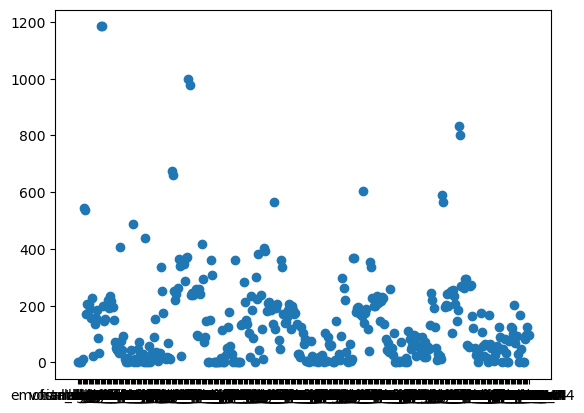

In [9]:
plt.scatter(x=df_train.drop(columns=["emotion"]).columns, y = n_outliers)
plt.show()

## Univariate feature selection

In [20]:
accuracy = []
f1 = []
for i in range(1,X.shape[1]):
    sel = SelectKBest(k=i)
    X_train_sel = sel.fit_transform(X_train, y_train)
    X_test_sel = sel.transform(X_test)
    clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
    clf.fit(X_train_sel, y_train)
    y_pred = clf.predict(X_test_sel)
    accuracy.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred, average="weighted"))

accuracy[107], f1[107]
# tempo di esecuzione circa 1m30s, 108 features è il miglior trade off tra qualità e quantità

c:\ProgramData\anaconda3\envs\env1\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [108] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\ProgramData\anaconda3\envs\env1\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\ProgramData\anaconda3\envs\env1\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [108] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\ProgramData\anaconda3\envs\env1\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\ProgramData\anaconda3\envs\env1\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [108] are constant.
  warnings.warn("Features %s 

(0.38782051282051283, 0.3817332011717924)

In [31]:
accuracy[107]

0.38782051282051283

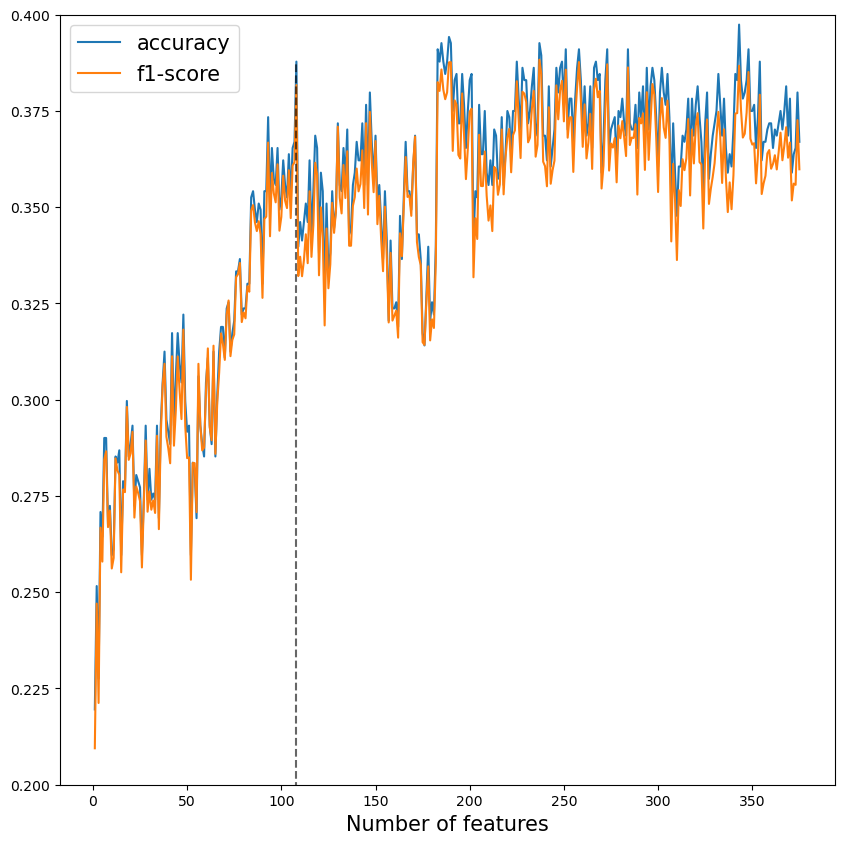

In [64]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(1,X.shape[1]), accuracy)
plt.plot(np.arange(1,X.shape[1]), f1)
plt.vlines(x=108, ymin=0, ymax=accuracy[107], linestyles="--", colors="k", alpha=0.6)
plt.legend(["accuracy", "f1-score"], fontsize=15)
plt.ylim(0.2, 0.4)
plt.xlabel("Number of features", fontsize=15)
plt.show()

In [11]:
sel = SelectKBest(k=108)
X_train_sel = sel.fit_transform(X_train, y_train)
X_test_sel = sel.transform(X_test)

clf_selkbest = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf_selkbest.fit(X_train_sel, y_train)
y_pred = clf_selkbest.predict(X_test_sel)

c:\ProgramData\anaconda3\envs\env1\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [108] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\ProgramData\anaconda3\envs\env1\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [12]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print("Average F1 score:\t", f1_score(y_test, y_pred, average="weighted"))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=2))

Accuracy 0.38782051282051283
Average F1 score:	 0.3817332011717924
F1-score [0.35632184 0.45945946 0.4040404  0.43373494 0.25       0.46728972
 0.23952096 0.42553191]
              precision    recall  f1-score   support

           0       0.40      0.32      0.36        96
           1       0.40      0.53      0.46        96
           2       0.39      0.42      0.40        96
           3       0.51      0.38      0.43        48
           4       0.25      0.25      0.25        48
           5       0.42      0.52      0.47        96
           6       0.28      0.21      0.24        96
           7       0.43      0.42      0.43        48

    accuracy                           0.39       624
   macro avg       0.39      0.38      0.38       624
weighted avg       0.38      0.39      0.38       624



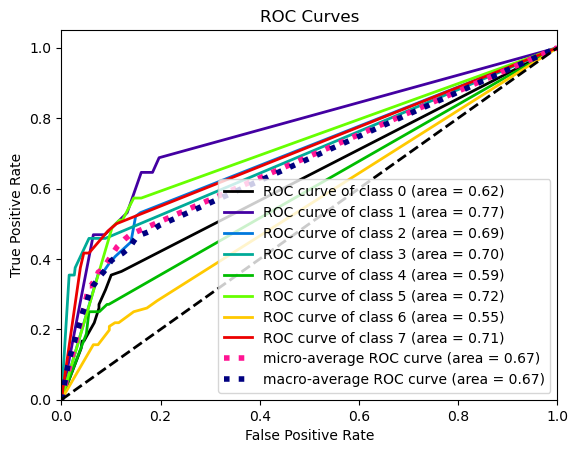

In [13]:
y_score = clf_selkbest.predict_proba(X_test_sel)
plot_roc(y_test, y_score)
plt.show()

## Select From Model

In [14]:
sel = SelectFromModel(DecisionTreeClassifier(min_samples_leaf=30, random_state=42, class_weight="balanced"))
X_train_sel = sel.fit_transform(X_train, y_train)
X_train_sel.shape
#X_test_sel = sel.transform(X_test)

(1828, 41)

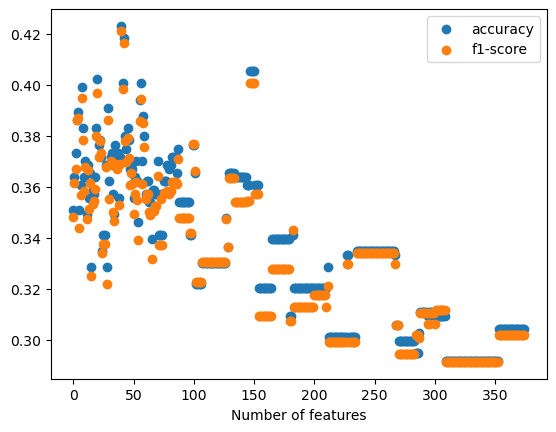

In [15]:
accuracy = []
f1 = []
for i in range(1,X.shape[1]):
    sel = SelectFromModel(DecisionTreeClassifier(min_samples_leaf=i, random_state=42, class_weight="balanced"))
    X_train_sel = sel.fit_transform(X_train, y_train)
    X_test_sel = sel.transform(X_test)
    clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
    clf.fit(X_train_sel, y_train)
    y_pred = clf.predict(X_test_sel)
    accuracy.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred, average="weighted"))

plt.scatter(x=np.arange(len(accuracy)), y=accuracy)
plt.scatter(x=np.arange(len(f1)), y=f1)
plt.legend(["accuracy", "f1-score"])
plt.xlabel("Number of features")
plt.show()

In [16]:
accuracy[42]

0.4182692307692308

In [17]:
clf_selfrommodel = DecisionTreeClassifier(min_samples_leaf=43, random_state=42, class_weight="balanced")
clf_selfrommodel.fit(X_train_sel, y_train)

y_pred = clf_selfrommodel.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print("Average F1 score:\t", f1_score(y_test, y_pred, average="weighted"))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=2))

Accuracy 0.36217948717948717
Average F1 score:	 0.3345988294169314
F1-score [0.15277778 0.51612903 0.30065359 0.45454545 0.27692308 0.52968037
 0.13636364 0.34710744]
              precision    recall  f1-score   support

           0       0.23      0.11      0.15        96
           1       0.46      0.58      0.52        96
           2       0.40      0.24      0.30        96
           3       0.36      0.62      0.45        48
           4       0.22      0.38      0.28        48
           5       0.47      0.60      0.53        96
           6       0.25      0.09      0.14        96
           7       0.29      0.44      0.35        48

    accuracy                           0.36       624
   macro avg       0.34      0.38      0.34       624
weighted avg       0.35      0.36      0.33       624



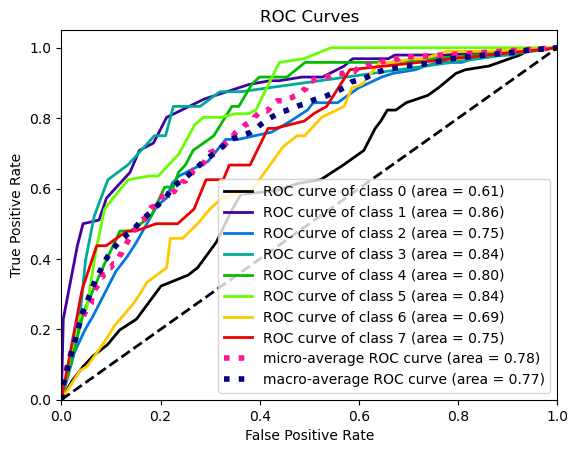

In [18]:
y_score = clf_selfrommodel.predict_proba(X_test_sel)
plot_roc(y_test, y_score)
plt.show()

## Recursive Feature Elimination

In [19]:
sel = RFE(DecisionTreeClassifier(), n_features_to_select=108)
X_train_sel = sel.fit_transform(X_train, y_train)
X_train_sel.shape

KeyboardInterrupt: 

In [ ]:
X_test_sel = sel.transform(X_test)

clf_rfe = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf_rfe.fit(X_train_sel, y_train)

y_pred = clf_rfe.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print("Average F1 score:\t", f1_score(y_test, y_pred, average="weighted"))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=2))

Accuracy 0.36217948717948717
Average F1 score:	 0.3543818962159608
F1-score [0.21468927 0.59903382 0.34741784 0.22857143 0.37894737 0.42328042
 0.24581006 0.33898305]
              precision    recall  f1-score   support

           0       0.23      0.20      0.21        96
           1       0.56      0.65      0.60        96
           2       0.32      0.39      0.35        96
           3       0.36      0.17      0.23        48
           4       0.38      0.38      0.38        48
           5       0.43      0.42      0.42        96
           6       0.27      0.23      0.25        96
           7       0.29      0.42      0.34        48

    accuracy                           0.36       624
   macro avg       0.35      0.35      0.35       624
weighted avg       0.36      0.36      0.35       624



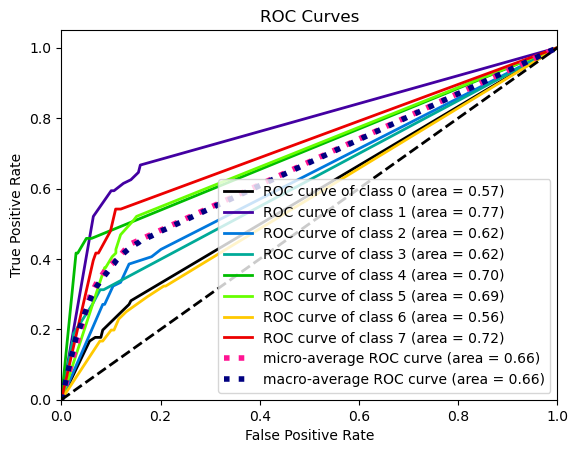

In [ ]:
y_score = clf_rfe.predict_proba(X_test_sel)
plot_roc(y_test, y_score)
plt.show()